In [1]:
import zarr
import dask_image.ndfilters
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt
import numpy as np

from skimage import color, util, filters, measure

## Iterate over sections on a slide

In [2]:
za = zarr.open('http://s3-far.jax.org/zarrtest/histopath_example.zarr', mode='r')

In [3]:
fullsize = za['0/0']
small = za['0/5'][...]  # This will immediate load as a numpy array
print('small', small.shape)
print('fullsize', fullsize.shape)

small (1, 3, 1, 1528, 3420)
fullsize (1, 3, 1, 48896, 109440)


In [4]:
small = np.moveaxis(small[0,:,0,:,:], 0, -1)
small.shape

(1528, 3420, 3)

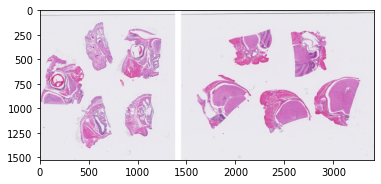

In [5]:
plt.imshow(small);

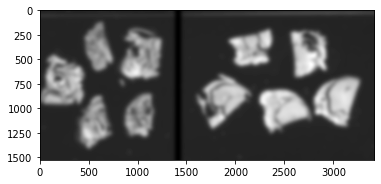

In [6]:
smallg = color.rgb2gray(small)
smallg = util.invert(smallg)
small_blurred = filters.gaussian(smallg, 20)
plt.imshow(small_blurred, cmap='gray');

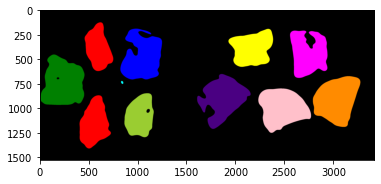

In [7]:
mask = small_blurred > filters.threshold_li(small_blurred)
labels = measure.label(mask)
plt.imshow(color.label2rgb(labels));

In [8]:
props = measure.regionprops(labels)

props = [x for x in props if x.area > 1000]

for prop in props:
    print(prop.bbox)

(125, 455, 622, 748)
(190, 820, 708, 1246)
(192, 1924, 579, 2380)
(210, 2553, 692, 2935)
(453, 3, 967, 454)
(652, 1604, 1211, 2151)
(674, 2786, 1191, 3271)
(799, 2229, 1251, 2767)
(848, 862, 1296, 1161)
(869, 404, 1411, 724)


In [9]:
slices = [np.array(prop.bbox) * (2**5) for prop in props]  # Pay attention to pyramid levels for correction

In [10]:
for y0, x0, y1, x1 in slices:
    crop = fullsize[0, :, 0, y0:y1, x0:x1]
    print(f'Apply your analysis here! Mean: {crop.mean()}')

Apply your analysis here! Mean: 208.42723843639553
Apply your analysis here! Mean: 201.33680203139588
Apply your analysis here! Mean: 197.15178100027023
Apply your analysis here! Mean: 193.6811439513221
Apply your analysis here! Mean: 200.2085176866385
Apply your analysis here! Mean: 208.32188500452813
Apply your analysis here! Mean: 196.59694736767764
Apply your analysis here! Mean: 195.69600674034916
Apply your analysis here! Mean: 203.817167342554
Apply your analysis here! Mean: 204.3853954976775


## Parallelize plate analysis using Dask bags

First lets construct a basic analysis for a single field

In [11]:
plate = zarr.open('/projects/researchit/djme/zarr_dask_examples/zarrs/plate_example.zarr/', mode='r')
plate.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,8
No. arrays,0
No. groups,8
Groups,"0, 1, 2, 3, 4, 5, 6, 7"


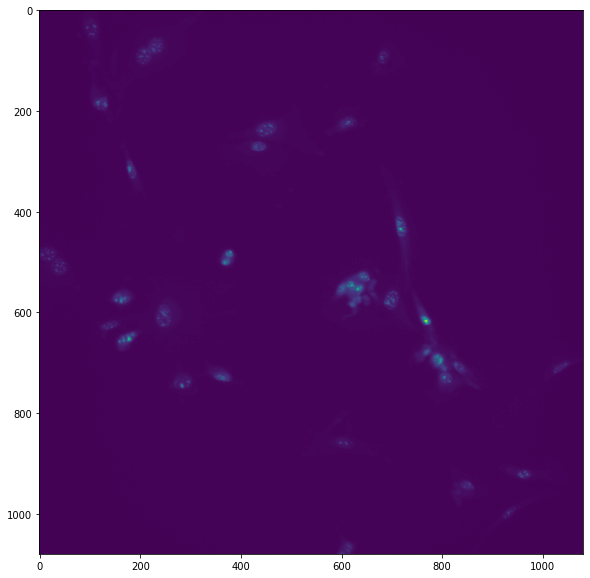

In [12]:
im = plate['2/7/9/0']
plt.figure(figsize = (10,10))
plt.imshow(im[0,0,0,:,:]);

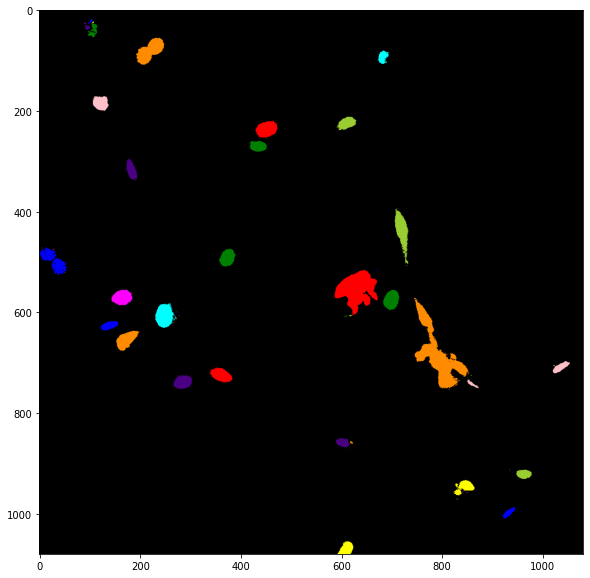

In [13]:
im = im[0,0,0,:,:]
im_thresh = im > filters.threshold_li(im)
im_lab = measure.label(im_thresh)
plt.figure(figsize = (10,10))
plt.imshow(color.label2rgb(im_lab));

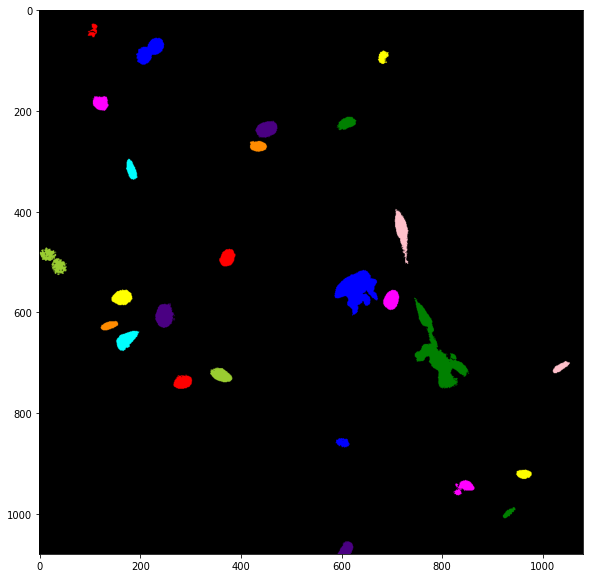

In [14]:
props = measure.regionprops(im_lab)
props = [x for x in props if x.area > 200]
mask = np.zeros_like(im)
for prop in props:
    mask[prop.coords[:,0], prop.coords[:,1]] = prop.label
plt.figure(figsize = (10,10))
plt.imshow(color.label2rgb(mask));

The following approach will parallelize analyses across fields, but process wells serially.  You could further parallelize by making each well a separate job on the cluster.

In [15]:
# Recreating what we did above as a function, to count objects

def count_objects(im):
    im = im[0, 0, 0, :, :]
    im_thresh = im > filters.threshold_li(im)
    im_lab = measure.label(im_thresh)
    props = measure.regionprops(im_lab)
    props = [x for x in props if x.area > 200]
    return len(props)

In [16]:
for row in plate:
    for col in plate[row]:
        
        #remove this next conditional to process the whole plate
        if row != '0':
            continue
        
        fields = [plate[f'{row}/{col}/{field}/0'] for field in plate[f'{row}/{col}']]
        well_bag = db.from_sequence(fields)
        counts = well_bag.map(count_objects).compute()
        well_count = np.sum(counts)
        print(f'Total cells in well {row},{col}: {well_count}')

Total cells in well 0,0: 148
Total cells in well 0,1: 140
Total cells in well 0,10: 140
Total cells in well 0,11: 167
Total cells in well 0,2: 128
Total cells in well 0,3: 157
Total cells in well 0,4: 147
Total cells in well 0,5: 135
Total cells in well 0,6: 163
Total cells in well 0,7: 121
Total cells in well 0,8: 140
Total cells in well 0,9: 143
